<a href="https://colab.research.google.com/github/seansothey/Research_Project/blob/main/Diabetic_Retinopathy_Detection_CNN(balanced_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://d2zo993x2i1w0h.cloudfront.net/live/2019/01/what-causes-diabetic-retinopathy-1024x642.jpg)

##Overview
Diabetic retinopathy is the leading cause of blindness in the working-age population of the developed world. It is estimated to affect over 93 million people.
The US Center for Disease Control and Prevention estimates that 29.1 million people in the US have diabetes and the World Health Organization estimates that 347 million people have the disease worldwide. Diabetic Retinopathy (DR) is an eye disease associated with long-standing diabetes. Around 40% to 45% of Americans with diabetes have some stage of the disease. Progression to vision impairment can be slowed or averted if DR is detected in time, however this can be difficult as the disease often shows few symptoms until it is too late to provide effective treatment.
Currently, detecting DR is a time-consuming and manual process that requires a trained clinician to examine and evaluate digital color fundus photographs of the retina. By the time human readers submit their reviews, often a day or two later, the delayed results lead to lost follow up, miscommunication, and delayed treatment.
Clinicians can identify DR by the presence of lesions associated with the vascular abnormalities caused by the disease. While this approach is effective, its resource demands are high. The expertise and equipment required are often lacking in areas where the rate of diabetes in local populations is high and DR detection is most needed. As the number of individuals with diabetes continues to grow, the infrastructure needed to prevent blindness due to DR will become even more insufficient.
The need for a comprehensive and automated method of DR screening has long been recognized, and previous efforts have made good progress using image classification, pattern recognition, and machine learning. With color fundus photography as input, the goal is to build an automated detection system to the limit of what is possible – ideally resulting in models with realistic clinical potential that can improve DR detection. This process requires many machine learning tasks and techniques to build a good classifier. To start, it is essential to obtain enough datasets, including useful information, such as number of attributes and classes.

##Datasets Description
The datasets are in image format with a large set of high-resolution retina images taken under a variety of imaging conditions. A left and right field is provided for every subject. Images are labeled with a subject id as well as either left or right (e.g. 1_left.jpeg is left eye of patient id 1).
Each image has been rated by clinicians on a scale 0 to 4 according to the presence of diabetic retinopathy.

*   0 - No DR
*   1 - Mild
*   2 - Moderate
*   3 - Severe
*   4 - Proliferative DR

The acquired images are in RGB form with high resolution JPEG format. Due to the extremely large size of this dataset, total to 82.23 GB, it was separated into archive folders. Each folder has around 8400 images, and total size about 8 GB. 
*   train.zip - the training set (5 folders)
*   test.zip - the test set (7 folders)
*   trainLabels.csv - contains the scores (0 to 4) for the training set

Dataset link: https://www.kaggle.com/c/diabetic-retinopathy-detection/data









#Setup

In [1]:
#!pip install tensorflow-gpu

In [2]:
!nvidia-smi

Mon Oct 26 21:18:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Common Import
import sklearn
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
import os
import time
import random

import tarfile
import cv2
from google.colab.patches import cv2_imshow

# to make this notebook's output stable across runs
np.random.seed(168)

from zipfile import ZipFile

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore")

# sklearn version > 0.20 is required 
sklearn.__version__
# Update sklearn -> !pip install -U scikit-learn

'0.22.2.post1'

Connect to google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing Data

In [ ]:
!unzip "/content/drive/My Drive/balanced_data.zip"

In [8]:
DR_data = os.listdir('/content/balanced_data')

In [9]:
len(DR_data)

2500

###Create the images dataset

In [10]:
def create_img_set(imgs_folder_path):
  x=[]
  lst = os.listdir(imgs_folder_path)
  for img in lst:
    img_imr = cv2.imread(os.path.join(imgs_folder_path, img))
    img_imr = cv2.resize(img_imr,(224,224)) # resize images
    x.append(np.array(img_imr))
  return x

In [11]:
data = create_img_set(os.path.join('/content/balanced_data'))

Show some images

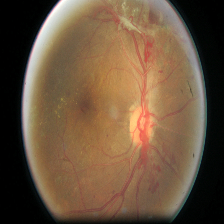

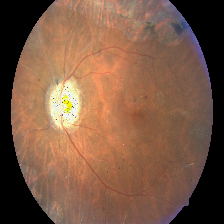

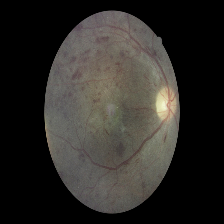

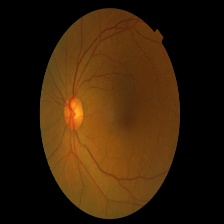

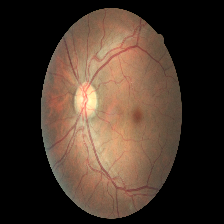

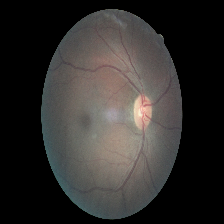

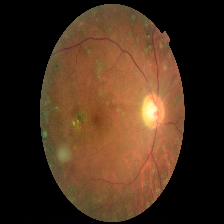

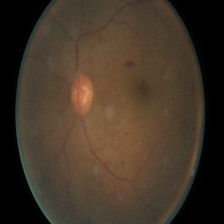

In [12]:
for i in range(0,8):
  cv2_imshow(data[i])

###Flattening the images dataset

In [13]:
data_flatten = np.array(data)

In [14]:
data_flatten.shape

(2500, 224, 224, 3)

###Scale the dataset

In [15]:
np.amax(data_flatten) # See the maximum value before scale

255

Scale to (0,1) by deviding with max. value 255

In [16]:
data_scale = data_flatten.astype('float32')/255.0

###Create label y

In [17]:
all_label = pd.read_csv("/content/trainLabels.csv")

In [18]:
all_label

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0


Let's check if the classes are balanced

In [19]:
print(all_label.groupby('level').nunique())

       image
level       
0      25810
1       2443
2       5292
3        873
4        708


Because we only use subset 1427 images; therefore, we have to extract assiciated label correctly.

In [20]:
label = []

In [21]:
file_dir = os.path.join('/content/train')
files = [os.path.join(file_dir, fname) for fname in DR_data]
for fname in DR_data:
  label.append(fname.split(".")[0]) 

In [22]:
label = pd.DataFrame(label,columns=['image'])

In [23]:
label

,image
0,15414_left
1,22520_left
2,14129_right
3,1541_left
4,7172_left
...,...
2495,2168_left
2496,408_left
2497,6165_right
2498,8640_right


In [24]:
new_label = pd.merge(label, all_label, on=['image'])

In [25]:
new_label

,image,level
0,15414_left,4
1,22520_left,4
2,14129_right,3
3,1541_left,2
4,7172_left,1
...,...,...
2495,2168_left,1
2496,408_left,0
2497,6165_right,1
2498,8640_right,3


Check the balance of the classes

In [26]:
print(new_label.groupby('level').nunique())

       image
level       
0        500
1        500
2        500
3        500
4        500


We can see, the subset contents imbalance clasess.

Let's verify with first and last file name to see if it's matched.

In [27]:
DR_data[0], new_label['image'][0]

('15414_left.jpeg', '15414_left')

In [28]:
DR_data[500], new_label['image'][500]

('10047_right.jpeg', '10047_right')

In [29]:
DR_data[1000], new_label['image'][1000]

('1475_left.jpeg', '1475_left')

Therefore, the new label is created correctly and good to go!!!

In [30]:
target = new_label['level']

Split training and testing set 80:20

In [31]:
X_train, X_test, y_train, y_test = train_test_split(data_scale, target, test_size=0.2, random_state=42)

In [32]:
class_name = ['No DR','Mild','Moderate','Severe','Proliferative DR']

In [33]:
y_train_cat = to_categorical(y_train, num_classes=len(class_name))

In [34]:
y_test_cat = to_categorical(y_test, num_classes=len(class_name))

##CNN 5-layers 

In [35]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers, optimizers
import tensorflow as tf
print(tf.__version__)

np.random.seed(168)

2.3.0


Instantiate some optimizers

In [36]:
sgd = optimizers.SGD(learning_rate=0.01)
rms = optimizers.RMSprop(learning_rate=0.001, rho=0.9)
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [53]:
cnn5 = Sequential([
    Conv2D(32, kernel_size=(5, 5), activation='relu', strides=(2,2), input_shape=(224,224,3)),  # 1st layer
    MaxPooling2D(pool_size=(2, 2),strides=2),

    Conv2D(32, kernel_size=(3,3), activation='relu'), # 2nd layer
    MaxPooling2D(pool_size=(2,2), strides=1),
    BatchNormalization(),

    Conv2D(32, kernel_size=(3,3), activation='relu',  kernel_regularizer=regularizers.l2(0.01)), # 3rd layer
    MaxPooling2D(pool_size=(2,2), strides=1),
    Dropout(0.2),

    Conv2D(16, kernel_size=(3,3), activation='relu'), # 4th layer
    MaxPooling2D(pool_size=(2,2), strides=1),
    BatchNormalization(),

    Conv2D(16, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)), # 5th layer
    MaxPooling2D(pool_size=(2,2), strides=1),
    Dropout(0.2),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

In [54]:
#For Classification use 'categorical_crossentropy' or 'binary_crossentropy'
#For Regression use 'mean_square_error'
cnn5.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              metrics=['accuracy'])

In [55]:
cnn5.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 110, 110, 32)      2432      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 53, 53, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 52, 52, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 52, 52, 32)        128       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 49, 49, 32)       

###Training the model

In [56]:
tr5 = cnn5.fit(X_train, y_train_cat, 
          batch_size=32, epochs=100, verbose=1, validation_split=0.2)

Epoch 1/100
50/50 [==============================] - 1s 19ms/step - loss: 2.1406 - accuracy: 0.1988 - val_loss: 2.0783 - val_accuracy: 0.1700
Epoch 2/100
50/50 [==============================] - 1s 15ms/step - loss: 2.0737 - accuracy: 0.2106 - val_loss: 2.0700 - val_accuracy: 0.2175
Epoch 3/100
50/50 [==============================] - 1s 15ms/step - loss: 2.0606 - accuracy: 0.2131 - val_loss: 2.0628 - val_accuracy: 0.2175
Epoch 4/100
50/50 [==============================] - 1s 15ms/step - loss: 2.0410 - accuracy: 0.2375 - val_loss: 2.0561 - val_accuracy: 0.2300
Epoch 5/100
50/50 [==============================] - 1s 15ms/step - loss: 2.0226 - accuracy: 0.2506 - val_loss: 2.0488 - val_accuracy: 0.2350
Epoch 6/100
50/50 [==============================] - 1s 15ms/step - loss: 2.0161 - accuracy: 0.2400 - val_loss: 2.0495 - val_accuracy: 0.2325
Epoch 7/100
50/50 [==============================] - 1s 15ms/step - loss: 1.9941 - accuracy: 0.2650 - val_loss: 2.0585 - val_accuracy: 0.2125
Epoch 

###See the accuracy

In [57]:
score5 = cnn5.evaluate(X_test, y_test_cat, verbose=0)
print('Test loss:', score5[0])
print('Test accuracy:', score5[1])

Test loss: 3.6017558574676514
Test accuracy: 0.3199999928474426


It's very low, let's try some more layers and augument dataset.

###See the prediction

In [58]:
pred_test = cnn5.predict_classes(X_test, verbose=0)

In [59]:
pred_test

array([4, 0, 4, 0, 0, 3, 2, 4, 0, 2, 2, 3, 4, 0, 3, 1, 0, 0, 2, 3, 3, 1,
       4, 1, 3, 2, 0, 4, 0, 2, 2, 0, 4, 1, 0, 2, 0, 3, 4, 3, 2, 2, 0, 3,
       3, 2, 3, 3, 0, 4, 2, 1, 2, 2, 1, 1, 2, 1, 2, 4, 1, 2, 3, 0, 1, 1,
       1, 0, 4, 3, 3, 0, 3, 0, 1, 1, 2, 0, 2, 0, 1, 2, 3, 4, 1, 3, 2, 4,
       3, 3, 4, 2, 3, 1, 1, 0, 0, 3, 1, 0, 0, 0, 0, 2, 0, 0, 3, 2, 2, 2,
       0, 4, 2, 1, 1, 2, 2, 1, 3, 1, 0, 1, 1, 3, 3, 0, 1, 1, 2, 0, 1, 2,
       0, 3, 4, 4, 2, 1, 4, 0, 0, 3, 0, 2, 0, 4, 3, 0, 1, 2, 0, 0, 0, 0,
       2, 1, 0, 0, 4, 0, 1, 0, 2, 2, 4, 1, 0, 1, 0, 2, 1, 2, 4, 4, 0, 0,
       0, 3, 2, 0, 0, 0, 0, 0, 1, 1, 0, 2, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0,
       3, 4, 0, 0, 4, 1, 0, 3, 0, 2, 1, 0, 3, 4, 0, 0, 2, 0, 3, 2, 4, 1,
       1, 2, 3, 3, 1, 4, 0, 1, 0, 3, 2, 0, 2, 0, 0, 4, 2, 2, 0, 1, 1, 2,
       0, 4, 0, 0, 0, 3, 2, 3, 2, 2, 1, 2, 4, 1, 1, 4, 4, 2, 4, 2, 0, 0,
       3, 0, 3, 4, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 3, 3, 2, 3, 1, 0, 0, 4,
       0, 0, 4, 2, 1, 2, 2, 2, 2, 3, 1, 0, 0, 4, 0,

In [60]:
# Save the model as h5 file
from tensorflow.keras.models import load_model
cnn5.save('CNN5_Layers.h5')

###Plot the learning curve

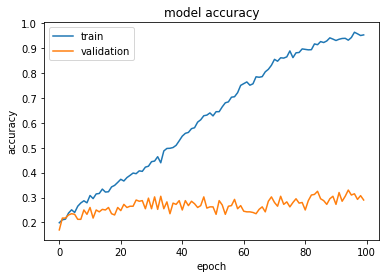

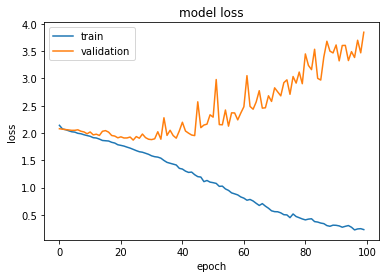

In [61]:
plt.plot(tr5.history['accuracy'])
plt.plot(tr5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(tr5.history['loss'])
plt.plot(tr5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

###Classification Report

In [62]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(6)]
print(classification_report(y_test, pred_test, target_names=class_name))

                  precision    recall  f1-score   support

           No DR       0.28      0.42      0.34       111
            Mild       0.36      0.33      0.34        97
        Moderate       0.26      0.28      0.27       107
          Severe       0.34      0.21      0.26       100
Proliferative DR       0.45      0.35      0.40        85

        accuracy                           0.32       500
       macro avg       0.34      0.32      0.32       500
    weighted avg       0.33      0.32      0.32       500



###Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

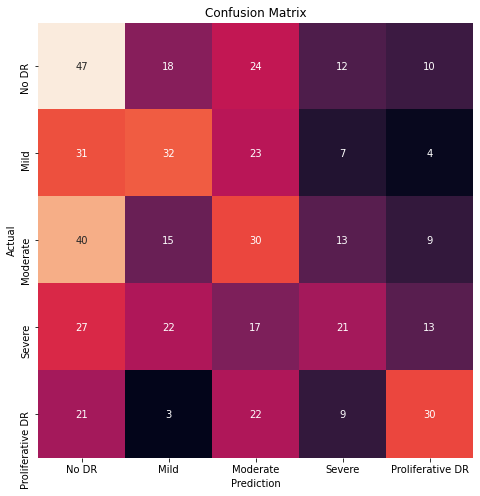

In [63]:
from sklearn.metrics import accuracy_score, confusion_matrix

fig, ax = plt.subplots(figsize=(8,8)) 
mat = confusion_matrix(pred_test, y_test)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_name,
            yticklabels=class_name)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')